In [1]:
%pip install ipywidgets

/Users/saeedsaadatipour/Git/ImageAlfred/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
from io import BytesIO

import matplotlib.pyplot as plt
import modal
import numpy as np
from PIL import Image


In [3]:
app = modal.App("ImageAlfread")

cuda_version = "12.4.0"
flavor = "devel"
operating_sys = "ubuntu22.04"
tag = f"{cuda_version}-{flavor}-{operating_sys}"

In [4]:
image = (
    modal.Image.from_registry(f"nvidia/cuda:{tag}", add_python="3.12")
    .apt_install("git")
    .pip_install(
        "opencv-contrib-python",
        "huggingface-hub",
        "Pillow",
        "numpy",
        # "opencv-contrib-python-headless",
    )
    .pip_install(
        "torch==2.4.1",
        "torchvision==0.19.1",
        index_url="https://download.pytorch.org/whl/cu124",
        gpu="T4",
    )
    .pip_install("git+https://github.com/luca-medeiros/lang-segment-anything.git",gpu="T4")
)

In [15]:
@app.function(gpu="T4", image=image)
def langsam_segment(
    image: Image.Image,
    prompt: str,
) -> list:
    from lang_sam import LangSAM  # type: ignore

    model = LangSAM(sam_type="sam2.1_hiera_large")
    results = model.predict([image], [prompt])
    return results


In [17]:
input_dir = "./src/assets/input"
output_dir = "./src/assets/output"
img_name = "test_1.jpg"
img = Image.open(f"{input_dir}/{img_name}").convert("RGB")

In [21]:
masks = None
with app.run():
    masks = langsam_segment.remote(img, "pants.")


In [25]:
masks

[{'scores': array([0.6627965], dtype=float32),
  'labels': ['pants'],
  'boxes': array([[ 386.53082, 1656.1442 , 1006.8546 , 1927.3484 ]], dtype=float32),
  'masks': array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
        shape=(1, 1930, 1340), dtype=float32),
  'mask_scores': array(0.9921875, dtype=float32)}]

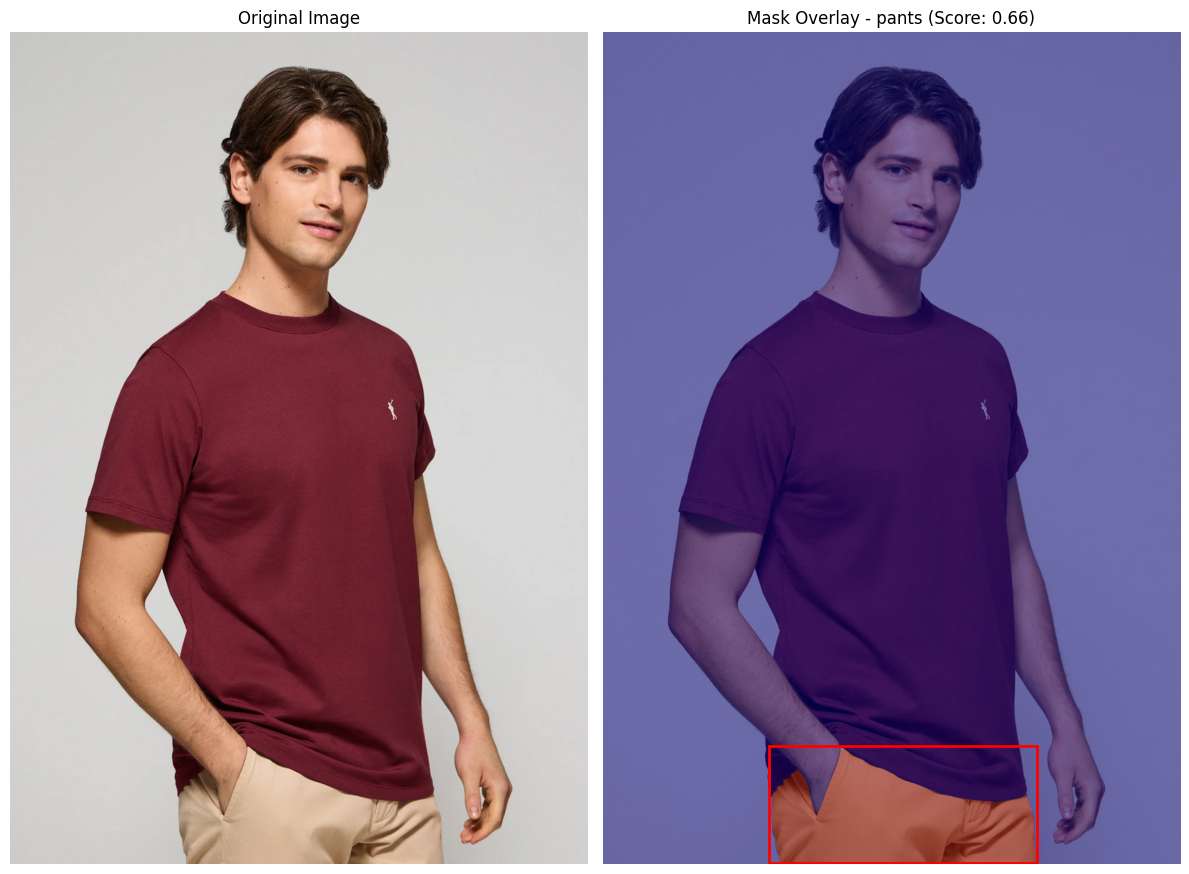

In [24]:

# Extract the mask from results
mask = masks[0]["masks"][0]
bbox = masks[0]["boxes"][0]
score = masks[0]["scores"][0]

# Create figure
plt.figure(figsize=(12, 10))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Plot mask overlay
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap="jet")
plt.title(f"Mask Overlay - {masks[0]['labels'][0]} (Score: {score:.2f})")
plt.axis("off")

# Add bounding box
x1, y1, x2, y2 = bbox
rect = plt.Rectangle(
    (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2
)
plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()


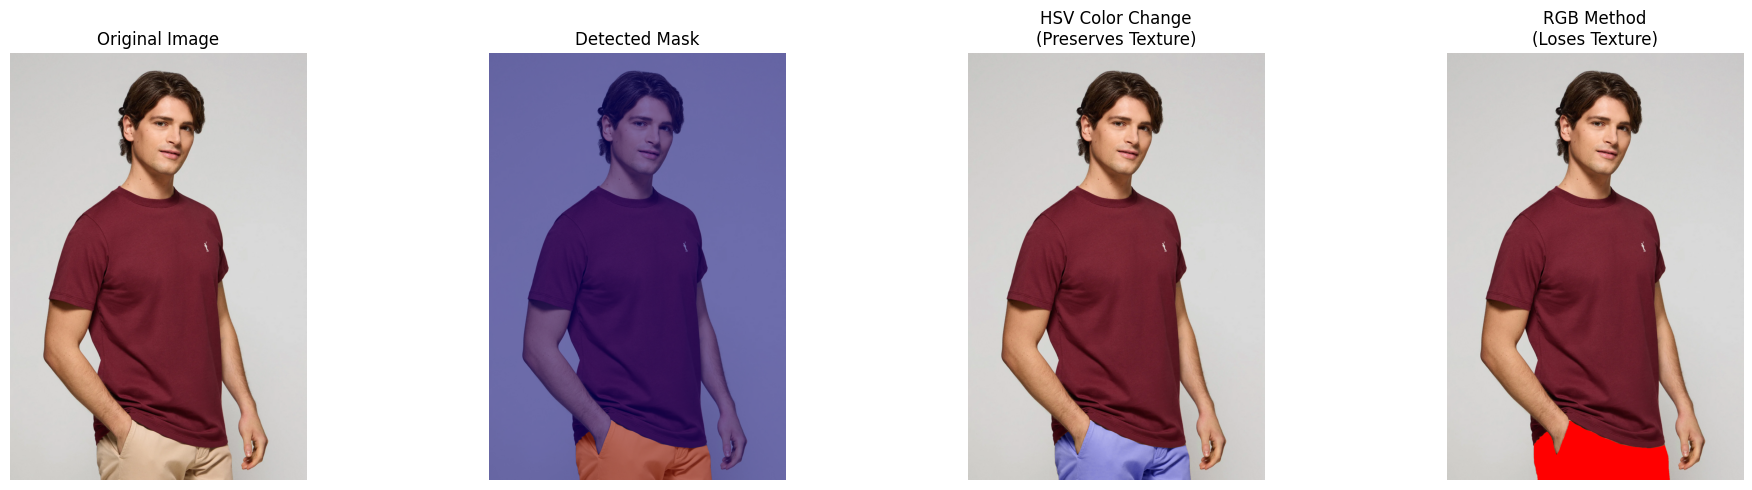

HSV colored image saved to: ./src/assets/output/hsv_colored_test_1.jpg


In [32]:
# HSV Color Space - Preserving texture and shadows
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

# Create a copy of the original image
img_hsv_colored = img.copy()
img_array = np.array(img_hsv_colored)

# Convert to HSV color space
img_hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV).astype(np.float32)

# Extract the mask
mask = masks[0]["masks"][0]
mask_bool = mask.astype(bool)

# Define new hue (0-179 in OpenCV HSV)
# Red: 0, Green: 60, Blue: 120, Yellow: 30, Purple: 150, Cyan: 90
new_hue = 120  # Blue color - change this value for different colors

# Apply new hue while preserving saturation and value (brightness/texture)
img_hsv[mask_bool, 0] = new_hue  # Change only the hue channel
# Optionally adjust saturation for more vivid colors
img_hsv[mask_bool, 1] = np.minimum(img_hsv[mask_bool, 1] * 1.2, 255)  # Increase saturation by 20%

# Convert back to RGB
img_hsv_result = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
img_hsv_colored = Image.fromarray(img_hsv_result)

# Display the result
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Mask visualization
plt.subplot(1, 4, 2)
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap="jet")
plt.title("Detected Mask")
plt.axis("off")

# HSV colored image
plt.subplot(1, 4, 3)
plt.imshow(img_hsv_colored)
plt.title("HSV Color Change\n(Preserves Texture)")
plt.axis("off")

# Previous RGB method for comparison
colored_img_rgb = img.copy()
colored_img_array = np.array(colored_img_rgb)
colored_img_array[mask_bool] = [255, 0, 0]  # Red
colored_img_rgb = Image.fromarray(colored_img_array.astype(np.uint8))

plt.subplot(1, 4, 4)
plt.imshow(colored_img_rgb)
plt.title("RGB Method\n(Loses Texture)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the HSV colored image
img_hsv_colored.save(f"{output_dir}/hsv_colored_{img_name}")
print(f"HSV colored image saved to: {output_dir}/hsv_colored_{img_name}")

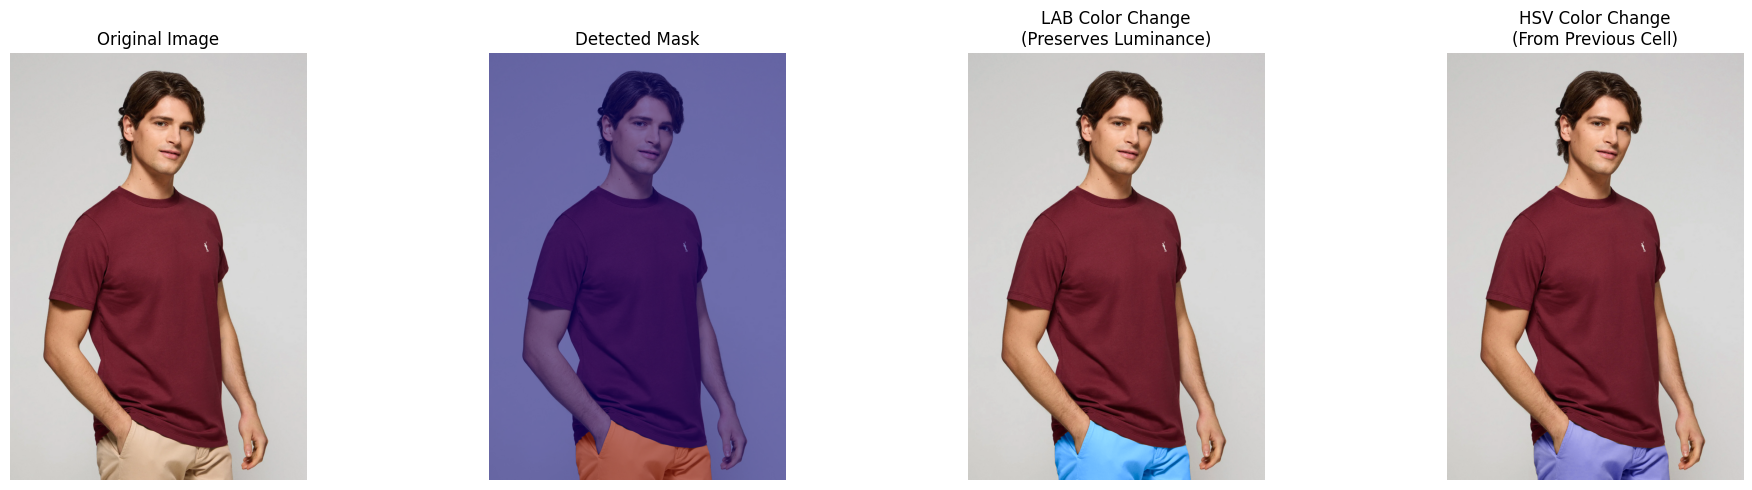

LAB colored image saved to: ./src/assets/output/lab_colored_test_1.jpg

Color Space Comparison:
- RGB: Direct color replacement (loses texture)
- HSV: Changes hue while preserving saturation and value
- LAB: Changes color while preserving luminance (best for texture preservation)


In [ ]:

# Create a copy of the original image
img_lab_colored = img.copy()
img_array = np.array(img_lab_colored)

# Convert to LAB color space using OpenCV
img_lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB).astype(np.float32)

# Extract the mask
mask = masks[0]["masks"][0]
mask_bool = mask.astype(bool)

# Define new color in LAB space (OpenCV LAB ranges)
# L: 0-255 (lightness)
# A: 0-255 (green-red, 128 is neutral)
# B: 0-255 (blue-yellow, 128 is neutral)
# Color examples:
# Green: a=80, b=128
# Red: a=180, b=160
# Blue: a=128, b=80
# Yellow: a=120, b=180
# Purple: a=180, b=100
new_a = 128  # Blue color (neutral on green-red axis)
new_b = 80   # Blue color (towards blue on blue-yellow axis)

# Apply new color while preserving L* (luminance/brightness/texture)
img_lab[mask_bool, 1] = new_a  # Change a* channel
img_lab[mask_bool, 2] = new_b  # Change b* channel
# L* channel (luminance) remains unchanged, preserving shadows and texture

# Convert back to RGB using OpenCV
img_lab_result = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
img_lab_colored = Image.fromarray(img_lab_result)

# Display the result
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Mask visualization
plt.subplot(1, 4, 2)
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap="jet")
plt.title("Detected Mask")
plt.axis("off")

# LAB colored image
plt.subplot(1, 4, 3)
plt.imshow(img_lab_colored)
plt.title("LAB Color Change\n(Preserves Luminance)")
plt.axis("off")

# HSV colored image for comparison
plt.subplot(1, 4, 4)
plt.imshow(img_hsv_colored)
plt.title("HSV Color Change\n(From Previous Cell)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the LAB colored image
img_lab_colored.save(f"{output_dir}/lab_colored_{img_name}")
print(f"LAB colored image saved to: {output_dir}/lab_colored_{img_name}")

# Print color space comparison
print("\nColor Space Comparison:")
print("- RGB: Direct color replacement (loses texture)")
print("- HSV: Changes hue while preserving saturation and value")
print("- LAB: Changes color while preserving luminance (best for texture preservation)")